In [199]:
!pip3 install umap-learn --quiet

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import os
import datetime as dt
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,f1_score,auc,plot_confusion_matrix,confusion_matrix,plot_roc_curve

In [198]:
def auc_score(model,X,y):
    rf_probs=model.predict_proba(X)
    rf_probs=rf_probs[:,1]
    prediction=model.predict(X)
    rf_precision,rf_recall,_=roc_auc_score(y,rf_probs)
    rf_f1,rf_auc=f1_score(y,prediction),auc(rf_recall,rf_precision)
    return rf_f1,rf_auc

In [41]:
df=pd.read_csv('model_df.csv').drop(['Unnamed: 0'],axis=1)

In [128]:
def auc_score(model,x,y):    
    rf_probs=model.predict_proba(x)
    rf_probs=rf_probs[:,1]
    predict=model.predict(x)
    rf_precision,rf_recall,_=precision_recall_curve(y,rf_probs)
    rf_f1,rf_auc=f1_score(y,predict),auc(rf_recall,rf_precision)
    return rf_f1,rf_auc

def rmse(model,x,y):
    rmse=np.sqrt(mean_squared_error(y,model.predict(x)))
    return rmse                        

In [85]:
def check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts=X_train.columns if features is None else features
        kws={parameters:p,**fixed}
        model=RandomForestClassifier(**kws)
        %time model.fit(X_train[fts],y_train)
        s=roc_auc_score(y_valid,model.predict_proba(X_valid[fts])[:,1])
        rf_f1,rf_auc=auc_score(model,X_valid[fts],y_valid)
        
        print('ROC AUC',s)
        print('F1',rf_f1)
        print('AUC',rf_auc)
        scores.append(s)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)

In [81]:
def split_df(df,ln_train,ln_valid):
    df=df.sample(frac=1.).reset_index(drop=True)
    val=df.iloc[-ln_valid:].reset_index(drop=True)
    train=df.iloc[:ln_valid].reset_index(drop=True)
    has_yes=train[train.has_gathered_two_customers==1]
    has_not_yes=train[train.has_gathered_two_customers==0].head(ln_train-len(has_yes))
    tra=pd.concat([has_yes,has_not_yes],axis=0).reset_index(drop=True)
    return tra,val

In [47]:
df=pd.get_dummies(df,columns=['initial_position_type'])

In [50]:
model_df=df.drop(['partner_position_id'],axis=1)

In [68]:
train,valid=split_df(model_df,500,500)

In [69]:
X_train,y_train=train.drop(['has_gathered_two_customers'],axis=1),train['has_gathered_two_customers']
X_valid,y_valid=valid.drop(['has_gathered_two_customers'],axis=1),valid['has_gathered_two_customers']

In [70]:
X_valid,y_valid=valid.drop(['has_gathered_two_customers'],axis=1),valid['has_gathered_two_customers']

In [77]:
d={'n_estimators':1000,'n_jobs':-1}
p='min_samples_leaf'
v=[1,3,5,10,25,40,50]

Fitting with min_samples_leaf=1
CPU times: user 3.61 s, sys: 1.71 s, total: 5.31 s
Wall time: 3.41 s
ROC AUC 0.925596553247901
F1 0.5785123966942148
AUC 0.5499283239403472
Fitting with min_samples_leaf=3
CPU times: user 3.23 s, sys: 1.68 s, total: 4.91 s
Wall time: 3.19 s
ROC AUC 0.9302732361172484
F1 0.5964912280701755
AUC 0.5939268666220808
Fitting with min_samples_leaf=5
CPU times: user 3.12 s, sys: 1.46 s, total: 4.58 s
Wall time: 3.27 s
ROC AUC 0.9313779643541023
F1 0.5471698113207547
AUC 0.6021019437962616
Fitting with min_samples_leaf=10
CPU times: user 3.12 s, sys: 1.47 s, total: 4.58 s
Wall time: 3.26 s
ROC AUC 0.9299418176461923
F1 0.5
AUC 0.6081523938002268
Fitting with min_samples_leaf=25
CPU times: user 3 s, sys: 1.41 s, total: 4.41 s
Wall time: 3.12 s
ROC AUC 0.9219325379290028
F1 0.38095238095238093
AUC 0.5713868760821055
Fitting with min_samples_leaf=40
CPU times: user 2.89 s, sys: 1.22 s, total: 4.11 s
Wall time: 3.19 s
ROC AUC 0.9101303579319487
F1 0.0
AUC 0.567728324

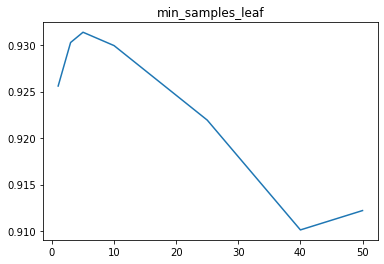

In [86]:
check_parameters(p,v,d)

In [87]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':10,'max_features':'sqrt',
   'class_weight':'balanced', 'random_state':428}

In [88]:
model=RandomForestClassifier(**d)
%time model.fit(X_train,y_train)

CPU times: user 3.14 s, sys: 1.48 s, total: 4.61 s
Wall time: 3.61 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=428, verbose=0,
                       warm_start=False)

In [89]:
def print_report(model,train,valid,target_label,feats=None):
    X_train,y_train=train.drop([target_label],axis=1),train[target_label].values
    X_valid,y_valid=valid.drop([target_label],axis=1),valid[target_label].values
    
    if feats is not None:
        X_train,X_valid = X_train[feats],X_valid[feats]
        
    train_pred,val_pred=model.predict(X_train),model.predict(X_valid)
    roc_auc_train=roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    roc_auc_val = roc_auc_score(y_valid,model.predict_proba(X_valid)[:,1])
    train_f1,train_auc=auc_score(model,X_train,y_train)
    val_f1,val_auc=auc_score(model,X_valid,y_valid)
        
    res =f"""
    Training ROC_AUC :{roc_auc_train}
    Training F1 : {train_f1}
    Training AUC: {train_auc}

    Validation ROC_AUC: {roc_auc_val}
    Validation F1: {val_f1}
    Validation AUC: {val_auc}

    """
    print(res)

    plot_roc_curve(model,X_valid,y_valid)
    plot_confusion_matrix(model,X_valid,y_valid)
    tn,fp,fn,tp=confusion_matrix(y_valid,val_pred).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)

    print('True Negatives:',tn)
    print('False Positives:',fp)
    print('False Negatives',fn)
    print('True Positives:',tp)
    print('Recall:',recall)
    print('Precision:',precision)



    Training ROC_AUC :0.9738008470402837
    Training F1 : 0.7513812154696132
    Training AUC: 0.8292794805701779

    Validation ROC_AUC: 0.9299049933716307
    Validation F1: 0.6043956043956044
    Validation AUC: 0.605841793040063

    
True Negatives: 373
False Positives: 65
False Negatives 7
True Positives: 55
Recall: 0.8870967741935484
Precision: 0.4583333333333333


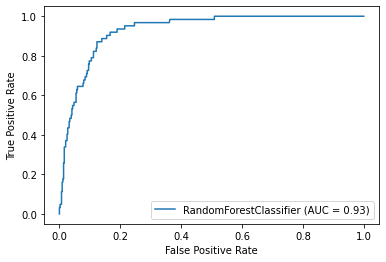

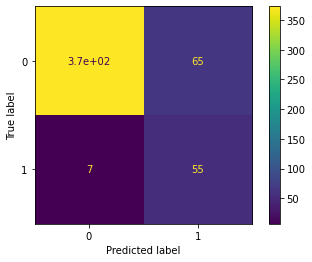

In [91]:
print_report(model,train,valid,'has_gathered_two_customers')

In [110]:
perm=permutation_importance(model,X_train,y_train,n_repeats=5,n_jobs=-1)
perm=pd.DataFrame({'importance':perm.importances_mean},index=X_train.columns)
perm.sort_values(by=['importance'],inplace=True)

In [161]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
rf_random.fit(train_features, train_labels)

In [182]:
def evaluate(model,X,y):
    prediction=model.predict(X_valid)
    rmse_valid=rmse(model,X_valid,y_valid)
    rmse_train=rmse(model,X_train,y_train)
    print('RMSE Valid',rmse_valid)
    print('RMSE Train',rmse_train)
    return rmse_valid

In [168]:
best_random=rf_random.best_estimator_
evaluate(best_random,X_valid,y_valid)

In [200]:
from sklearn.cluster import KMeans
import umap
from scipy.spatial.distance import cdist

In [ ]:
import umap
umap=umap.UMAP()
umap=umap.fit(train)
umap_embedding=umap.transform(train)

distortions=[]
K=range(2,30)
for k in tqdm(K):
    k_means=KMeans(n_clusters=k,random_state=42).fit(umap_embedding)
    k_means.fit(umap_embedding)
    distortions.append(sum(np.min(cdist(umap_embedding,k_means.cluster_centers_,'euclidean'),axis=1))/train.shape[0])

x_line=[K[0],K[-1]]
y_line=[distortions[0],distortions[-1]]
plt.plot(K,distortions,'b-')
plt.plot(x_line,y_line,'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Curve of Optimal k')

k=3
kmeans=KMeans(n_clusters=k,random_state=42)
y_umap_pred=kmeans.fit_predict(umap_embedding)
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(umap_embedding[:,0],umap_embedding[:,1],
              palette=sns.hls_palette(k,l=.4,s=.9),hue=y_umap_pred).set_title('')

